
<a id="libraries-and-utilities"></a>
# **Libraries and Utilities**

Import the required libraries, including Optuna for hyperparameter optimization.
    

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, train_test_split
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import optuna
from tqdm import tqdm
import warnings
import os
import shutil

from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam
import torch
import torch.nn as nn
import torch.optim as optim
import os
from sklearn.decomposition import PCA
from torch.utils.data import DataLoader, TensorDataset

from scipy.optimize import minimize

from sklearn.ensemble import VotingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import seaborn as sns

import json
import joblib



warnings.filterwarnings("ignore")
optuna.logging.set_verbosity(optuna.logging.WARNING)

# **Configuration**
Important configuration for the experiments

In [2]:
class Config:
    # Dataset base path
    BASE_DATA_PATH = '/kaggle/input/dataset-k-fold'

    # Data configuration
    MONTHS = ['2019-04', '2019-10', '2020-04', '2020-10']
    SELECTED_FEATURES = ['TCW', 'TCLW', 'R250', 'R500', 'R850', 'U850', 'V850', 'EWSS', 'KX', 'CAPE', 'SSHF', 'PEV']
    USE_LOCATION = False
    TARGET_FEATURE = 'AWS' 
    PAST_LAGS = [1, 2, 3, 4, 5, 6]
    PAST_FEATURES = ['AWS']
    PREDICT_STEP = 0

    # Optuna configuration
    OPTUNA_TRIALS = 50
    N_JOBS = 4
    
    # Other experiment configuration
    CSI_THRESHOLD = 0.5
    RANDOM_STATE = 42
    
    # Output configuration
    OUTPUT_DIR = 'AWS_ERA5_FEATURES'
    METRICS = ['RMSE', 'Pearson R', 'Bias', 'CSI']
    SAVE_PREDICTIONS = True  # Flag to control prediction saving


<a id="hyperparameter-tuning"></a>
# **Hyperparameter Tuning with Optuna**
    

In [3]:
def is_gpu_available():
    try:
        import torch
        return torch.cuda.is_available()
    except ImportError:
        return False

In [4]:
def optimize_xgboost(folds_data):
    """
    Optimize XGBoost hyperparameters using Optuna across provided fold data.
    
    Args:
        folds_data (list): List of (X_train, y_train, X_val, y_val) tuples.
        n_trials (int): Number of Optuna trials.

    Returns:
        dict: Best hyperparameters minimizing mean RMSE across folds.
    """
    if is_gpu_available():
        tree_method = "gpu-hist"
    else:
        tree_method = "hist"

    def objective(trial):
        params = {
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "reg_lambda": trial.suggest_float("lambda", 1e-5, 10.0),
            "reg_alpha": trial.suggest_float("alpha", 1e-5, 10.0),
            "tree_method": tree_method,
            "n_estimators": 1000,
            "random_state": Config.RANDOM_STATE,
            "n_jobs" : Config.N_JOBS,
        }

        rmse_scores = []

        for X_train, y_train, X_val, y_val in folds_data:
            model = XGBRegressor(**params)
            model.fit(
                X_train,
                y_train,
                eval_set=[(X_val, y_val)],
                eval_metric="rmse",
                early_stopping_rounds=50,
                verbose=0
            )
            preds = model.predict(X_val)
            rmse = mean_squared_error(y_val, preds, squared=False)
            rmse_scores.append(rmse)

        mean_rmse = np.mean(rmse_scores)
        return mean_rmse  # minimize

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=Config.OPTUNA_TRIALS)

    print("Best Mean RMSE:", study.best_value)
    print("Best Parameters:", study.best_params)

    return study.best_params

# **Data handling**

In [5]:
def feature_selection(df, selected_features=None, target_feature='AWS'):
    """
    Return a DataFrame with only selected features.
    If selected_features is None, return the full DataFrame.
    """
    if selected_features is None:
        return df
    else:
        selected_features = selected_features + [target_feature]
        return df[selected_features]


In [6]:
def add_past_data(df, lags=None, past_features=None):
    """
    Add past feature values to the DataFrame with pattern {feature}-{lag}h.
    Sorts the data by ROW -> COL -> DATETIME, then adds lag features.
    
    Parameters:
        df (pd.DataFrame): Input DataFrame.
        lags (list of int): List of lag hours to apply.
        past_features (list of str): List of feature column names to lag.
        
    Returns:
        pd.DataFrame: DataFrame with additional lagged columns.
    """
    if lags is None or past_features is None:
        return df

    # Sort the DataFrame
    df = df.sort_values(by=['ROW', 'COL', 'DATETIME'], ascending=[True, True, True])

    # Ensure datetime is datetime type
    df['DATETIME'] = pd.to_datetime(df['DATETIME'])

    # Create lag features
    for feature in past_features:
        for lag in lags:
            lagged_col = f"{feature}-{lag}h"
            df[lagged_col] = (
                df.groupby(['ROW', 'COL'])[feature]
                .shift(lag)
            )
    return df

In [7]:
def add_future_target(df):
    if Config.PREDICT_STEP == 0:
        return df, Config.TARGET_FEATURE

    # Create name for the future target column
    future_target_col = f"{Config.TARGET_FEATURE}+{Config.PREDICT_STEP}h"

    # Sort the DataFrame by DATETIME to ensure proper alignment
    df = df.sort_values(["ROW", "COL", "DATETIME"])

    # Group by ROW and COL and shift the target feature upward to get the future value
    df[future_target_col] = (
        df.groupby(["ROW", "COL"])[Config.TARGET_FEATURE]
        .shift(-Config.PREDICT_STEP)
    )

    # Drop the original target feature
    df = df.drop(columns=[Config.TARGET_FEATURE])

    return df, future_target_col

In [8]:
def load_dataset(df):
    # Select important features
    init_features = ["DATETIME", "ROW", "COL"] + Config.SELECTED_FEATURES
    input_df = feature_selection(df, selected_features=init_features, target_feature=Config.TARGET_FEATURE)

    # Add past data
    past_added_df = add_past_data(input_df, Config.PAST_LAGS, Config.PAST_FEATURES)

    # Add future predict step
    future_pred_df, final_target_feature = add_future_target(past_added_df)

    # Replace infs and drop NaNs
    future_pred_df.replace(-np.inf, np.nan, inplace=True)
    final_df = future_pred_df.dropna(subset=[final_target_feature])

    # Define features and target
    if Config.USE_LOCATION:    
        X = final_df.drop(columns=[final_target_feature, 'DATETIME'])
    else:
        X = final_df.drop(columns=[final_target_feature, 'DATETIME', 'ROW', 'COL'])

    y = final_df[final_target_feature]

    return final_df, X, y


In [9]:
def load_folds_data(base_path, n_splits=5):
    """
    Load fold data from structured folders into a list of tuples.
    Each tuple: (X_train, y_train, X_val, y_val)
    """
    folds_data = []

    for fold in range(1, n_splits + 1):
        fold_path = os.path.join(base_path, f"fold_{fold}")
        train_file = os.path.join(fold_path, "processed_train.csv")
        val_file = os.path.join(fold_path, "processed_val.csv")

        train_df = pd.read_csv(train_file)
        val_df = pd.read_csv(val_file)

        _, X_train, y_train = load_dataset(train_df)
        _, X_val, y_val = load_dataset(val_df)

        folds_data.append((X_train, y_train, X_val, y_val))

    return folds_data


# **Model evaluation**

In [10]:
import numpy as np
from sklearn.metrics import mean_squared_error

def compute_csi(y_true, y_pred, threshold):
    y_true_event = y_true >= threshold
    y_pred_event = y_pred >= threshold
    tp = np.sum(y_true_event & y_pred_event)
    fp = np.sum(~y_true_event & y_pred_event)
    fn = np.sum(y_true_event & ~y_pred_event)
    denominator = tp + fp + fn
    return tp / denominator if denominator != 0 else 0.0

def precipitation_metrics(y_true, y_preds, csi_threshold=Config.CSI_THRESHOLD):
    # Convert inputs to numpy arrays
    y_true = np.array(y_true)
    y_preds = np.array(y_preds)
    
    # Pearson Correlation Coefficient (R)
    y_true_mean = np.mean(y_true)
    y_preds_mean = np.mean(y_preds)
    numerator = np.sum((y_true - y_true_mean) * (y_preds - y_preds_mean))
    denominator = np.sqrt(np.sum((y_true - y_true_mean) ** 2) * np.sum((y_preds - y_preds_mean) ** 2))
    R = numerator / denominator if denominator != 0 else 0

    # RMSE
    RMSE = np.sqrt(mean_squared_error(y_true, y_preds))

    # Bias
    Bias = np.mean(y_preds - y_true)

    # CSI
    CSI = compute_csi(y_true, y_preds, threshold=csi_threshold)

    # Print metrics
    print(f"RMSE     : {RMSE:.4f}")
    print(f"Pearson R: {R:.4f}")
    print(f"Bias     : {Bias:.4f}")
    print(f"CSI      : {CSI:.4f} (Threshold={csi_threshold})")
    
    return {
        "RMSE": RMSE,
        "Pearson R": R,
        "Bias": Bias,
        "CSI": CSI
    }


In [11]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

def model_evaluation(X_final_train, y_final_train, X_test, y_test, test_df, best_params, output_dir, base_path):
    # Extract the tag like "2019-04"
    tag = os.path.basename(os.path.normpath(base_path))

    # Create subfolder
    save_dir = os.path.join(output_dir, tag)
    os.makedirs(save_dir, exist_ok=True)

    # Train model
    print("Training model...")
    model = XGBRegressor(**best_params)
    model.fit(X_final_train, y_final_train)

    # Predict on test
    y_preds = model.predict(X_test)

    
    # Plot and save feature importance
    fig, ax = plt.subplots(figsize=(10, 8))
    plot_importance(model, ax=ax, max_num_features=20, importance_type='gain')  # you can change 'gain' to 'weight' or 'cover'
    plt.title("Feature Importance")
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "feature_importance.png"))
    plt.show()

    # Evaluate
    metrics = precipitation_metrics(y_test, y_preds)

    # Combine predictions with metadata
    prediction_df = test_df[["DATETIME", "ROW", "COL"]].copy()
    prediction_df["y_true"] = y_test
    prediction_df["y_pred"] = y_preds

    # Save results inside save_dir
    prediction_df.to_csv(os.path.join(save_dir, "predictions.csv"), index=False)

    # Save best_params as JSON
    with open(os.path.join(save_dir, "best_params.json"), "w") as f:
        json.dump(best_params, f, indent=4)

    # Save trained model
    joblib.dump(model, os.path.join(save_dir, "model.pkl"))

    print(f"Saved results in: {save_dir}")
    return model, metrics

# **Training and Evalutation for a month**

In [12]:
import os
import pandas as pd

def process_a_month(base_path, output_dir='output'):
    # Training and optimizing hyperparameters
    folds_data = load_folds_data(base_path, n_splits=5)
    best_xgb_params = optimize_xgboost(folds_data)
    if is_gpu_available():
        tree_method = "gpu-hist"
    else:
        tree_method = "hist"

    best_xgb_params['tree_method'] = tree_method
    best_xgb_params['n_estimators'] = 1000
    best_xgb_params['random_state'] = Config.RANDOM_STATE

    # Evaluation
    fold5_path = os.path.join(base_path, 'fold_5')
    
    final_train_df_1 = pd.read_csv(os.path.join(fold5_path, 'processed_train.csv'))
    final_train_df_2 = pd.read_csv(os.path.join(fold5_path, 'processed_val.csv'))
    final_train_df = pd.concat((final_train_df_1, final_train_df_2))
    _ ,X_final_train, y_final_train = load_dataset(final_train_df)

    test_df = pd.read_csv(os.path.join(fold5_path, 'merged_test.csv'))
    test_df, X_test, y_test = load_dataset(test_df)

    model, metrics = model_evaluation(X_final_train, y_final_train, X_test, y_test, test_df, best_xgb_params, output_dir, base_path)
    return model, metrics


In [13]:
import os
import numpy as np
import pandas as pd

def process_all_months(dataset_folder_path, output_dir='output'):
    all_metrics = {}

    for month_folder in sorted(Config.MONTHS):
        base_path = os.path.join(dataset_folder_path, month_folder)
        if os.path.isdir(base_path):
            print(f"\n--- Processing {month_folder} ---")
            _, metrics = process_a_month(
                base_path=base_path,
                output_dir=output_dir
            )
            all_metrics[month_folder] = metrics

    if all_metrics:
        # Convert dictionary to DataFrame
        df = pd.DataFrame.from_dict(all_metrics, orient='index')

        # Calculate average and append as new row
        average_metrics = df.mean().to_dict()
        df.loc["Average"] = average_metrics

        # Save to CSV
        os.makedirs(output_dir, exist_ok=True)
        df.to_csv(os.path.join(output_dir, "all_metrics_summary.csv"))

        # Print average metrics
        print("\n=== Average Metrics Across All Months ===")
        for k, v in average_metrics.items():
            print(f"{k}: {v:.4f}")


# **Run the experiment**



--- Processing 2019-04 ---
Best Mean RMSE: 0.3989195507792005
Best Parameters: {'learning_rate': 0.03853334510175183, 'max_depth': 3, 'subsample': 0.6518404091027336, 'colsample_bytree': 0.840590097825511, 'lambda': 4.120092624881442, 'alpha': 7.868799780362146}
Training model...


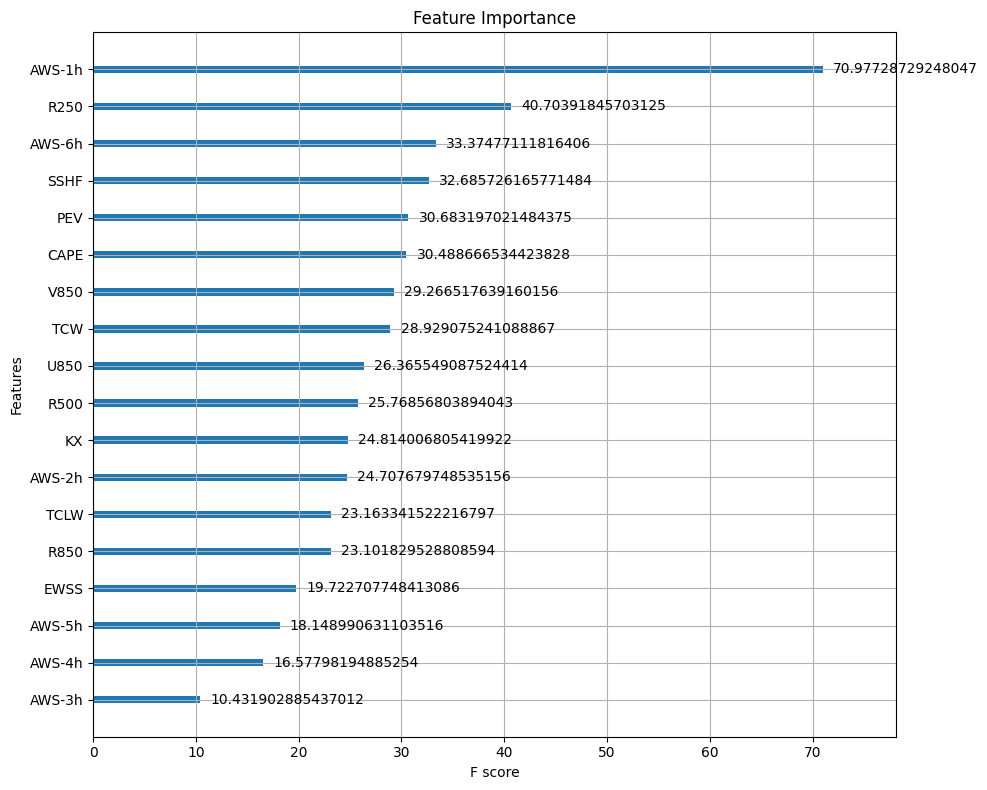

RMSE     : 2.1964
Pearson R: 0.2822
Bias     : 1.7890
CSI      : 0.0476 (Threshold=0.5)
Saved results in: AWS_ERA5_FEATURES/2019-04

--- Processing 2019-10 ---
Best Mean RMSE: 0.7352191527731077
Best Parameters: {'learning_rate': 0.03187721549280273, 'max_depth': 10, 'subsample': 0.6351342867749886, 'colsample_bytree': 0.6565325589701326, 'lambda': 6.922402961192002, 'alpha': 3.369184231370299}
Training model...


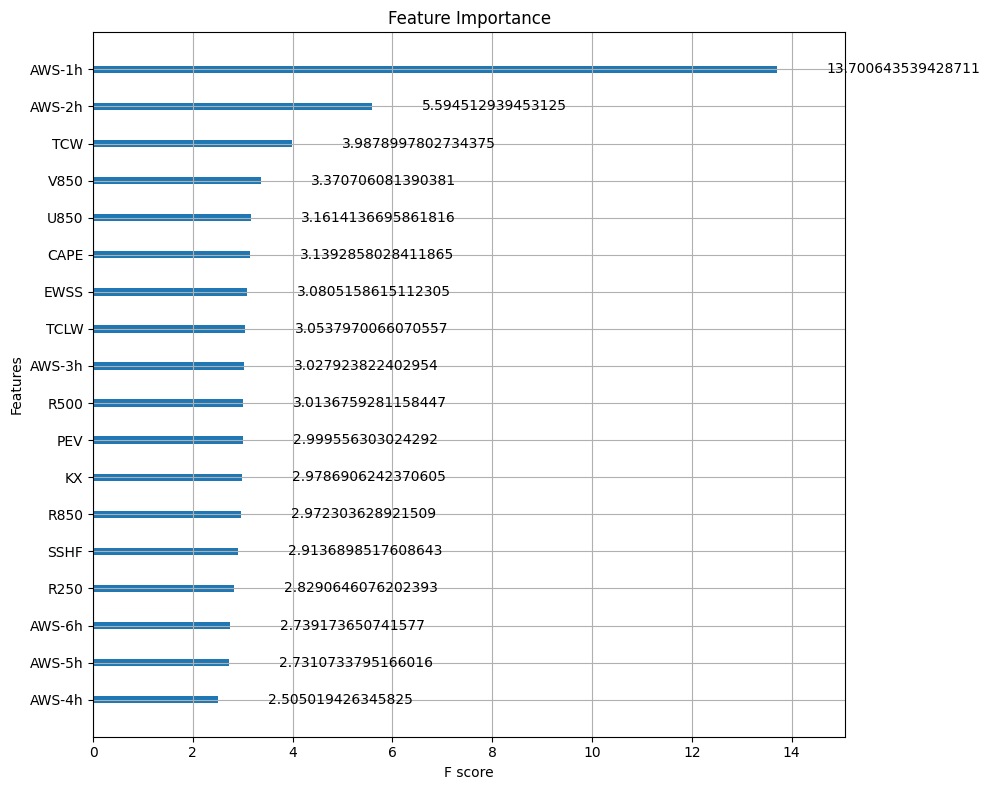

RMSE     : 1.7995
Pearson R: 0.0565
Bias     : 1.3575
CSI      : 0.0572 (Threshold=0.5)
Saved results in: AWS_ERA5_FEATURES/2019-10

--- Processing 2020-04 ---
Best Mean RMSE: 0.5084569284877755
Best Parameters: {'learning_rate': 0.06851582145654705, 'max_depth': 3, 'subsample': 0.5345104094263398, 'colsample_bytree': 0.960413117433489, 'lambda': 4.06098619164611, 'alpha': 8.535639899823739}
Training model...


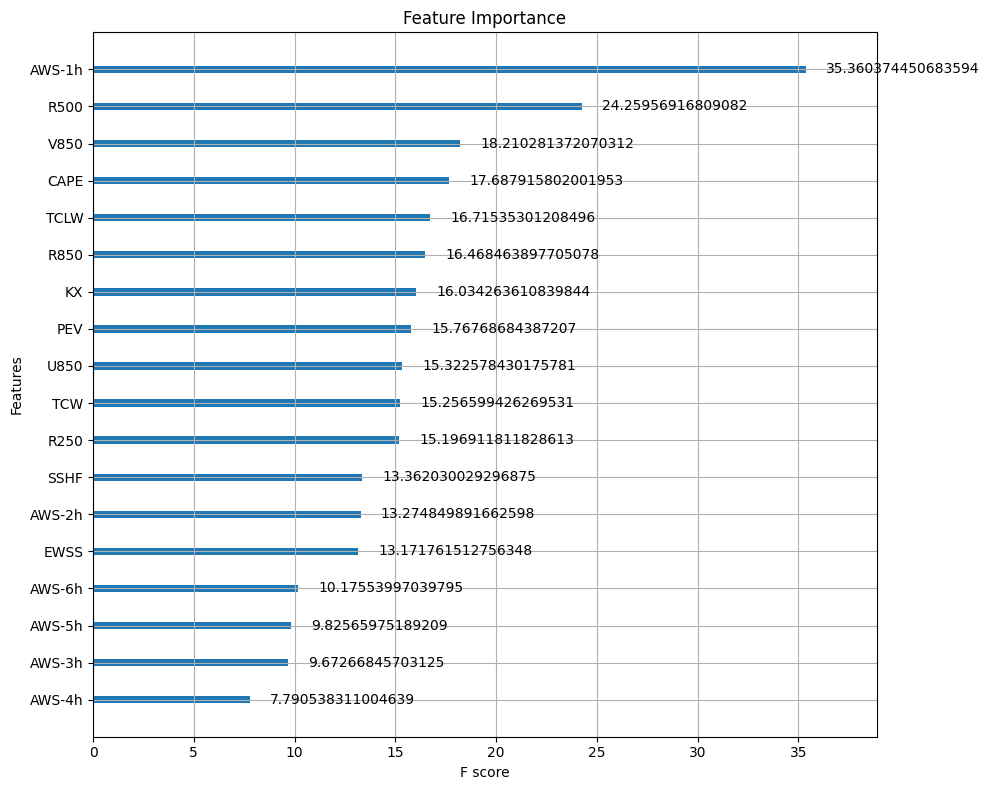

RMSE     : 0.9013
Pearson R: 0.2539
Bias     : 0.6007
CSI      : 0.0185 (Threshold=0.5)
Saved results in: AWS_ERA5_FEATURES/2020-04

--- Processing 2020-10 ---
Best Mean RMSE: 0.8972609261814231
Best Parameters: {'learning_rate': 0.02349970119379445, 'max_depth': 10, 'subsample': 0.8808119957702897, 'colsample_bytree': 0.8357656224928224, 'lambda': 6.180050818234224, 'alpha': 8.903056663832814}
Training model...


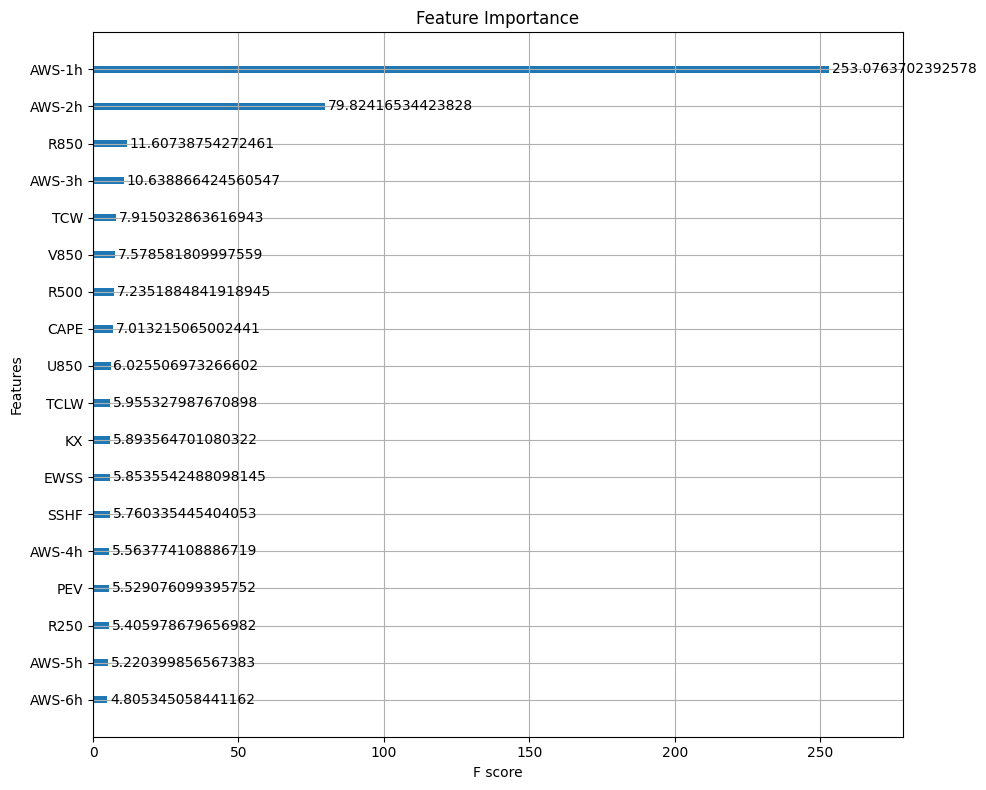

RMSE     : 1.8099
Pearson R: 0.4770
Bias     : 0.8615
CSI      : 0.1548 (Threshold=0.5)
Saved results in: AWS_ERA5_FEATURES/2020-10

=== Average Metrics Across All Months ===
RMSE: 1.6768
Pearson R: 0.2674
Bias: 1.1521
CSI: 0.0695


In [14]:
process_all_months(Config.BASE_DATA_PATH, Config.OUTPUT_DIR)